In [1]:
from collections import OrderedDict
import os
import pickle

import numpy as np
import numpy.typing as npt
import torch
from torch import Tensor

from autoencoders import CnnAutoencoder, DenseAutoencoder, DenseAutoencoder2
from scm.box import BoxSCM

import utils

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Function to add a border around the image
def add_border(ax, color='black', lw=2):
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                     color=color, fill=False, lw=lw)
    ax.add_patch(rect)


In [2]:
data_dir = "data/3b/1"
latent_dim = 64

In [3]:
# Load data generation config
with open(
    os.path.join(data_dir, "generate_data_cfg.pkl"),
    "rb", pickle.HIGHEST_PROTOCOL
) as f:
    data = pickle.load(f)

num_balls: int = data["num_balls"]
n: int = data["n"]
degree: int = data["degree"]
box_size: int = data["box_size"]
intervention_order: npt.NDArray[np.int_] = data["intervention_order"]
n_samples: int = data["n_samples"]
width: int = data["width"]
height: int = data["height"]
ball_radius: int = data["ball_radius"]
# data_dir = data["data_dir"]  # DON'T!! we are supplying this
scm: BoxSCM = data["scm"]

# Ground truth graph
# Note the permutation by the intervention order
dag_gt = scm.adj_mat
dag_gt = dag_gt[intervention_order, :][:, intervention_order]

# Load z and x data
data = np.load(os.path.join(data_dir, "z_and_x.npz"))
zs_obs = data["zs_obs"]
xs_obs = data["xs_obs"]
zs_obs = torch.from_numpy(zs_obs).float()
xs_obs = torch.from_numpy(xs_obs).float() / 255.0
print(f"Loaded z and x data.")
print(f"{zs_obs.shape = }, {xs_obs.shape = }")

Loaded z and x data.
zs_obs.shape = torch.Size([10000, 6]), xs_obs.shape = torch.Size([10000, 3, 64, 64])


In [4]:
# Load the trained autoencoder step 1
autoenc1 = CnnAutoencoder(latent_dim)
autoenc1.load_state_dict(torch.load(os.path.join(data_dir, f"autoenc_reconstruct_{latent_dim}.pth"), weights_only=True))
autoenc1.requires_grad_(False)

encoder1 = autoenc1.get_submodule("encoder").requires_grad_(False)
decoder1 = autoenc1.get_submodule("decoder").requires_grad_(False)

In [5]:
# Load the trained autoencoder step 2
autoenc2 = DenseAutoencoder2(n, latent_dim)
autoenc2.load_state_dict(torch.load(os.path.join(data_dir, f"autoenc_disentangle_{latent_dim}.pth"), weights_only=True))
autoenc2.requires_grad_(False)

encoder2 = autoenc2.get_submodule("encoder").requires_grad_(False)
decoder2 = autoenc2.get_submodule("decoder").requires_grad_(False)

In [6]:
encoder = torch.nn.Sequential(encoder1, encoder2)
decoder = torch.nn.Sequential(decoder2, decoder1)

In [7]:
### Part 2: Analysis

## Latent variables recovery
# Mean correlation coefficient
zhats_obs = encoder(xs_obs)
assert isinstance(zhats_obs, Tensor)
z_mcc = utils.mcc(zhats_obs.detach().cpu().numpy(), zs_obs.detach().cpu().numpy())
print(f"{z_mcc = }")

z_mcc = np.float64(0.15916575017522125)


tensor([[0.4217, 0.0191, 0.8356, 0.9145, 0.2534, 0.5301],
        [0.8894, 0.2374, 0.5681, 0.6546, 0.3086, 0.5335],
        [0.5005, 0.1426, 0.4770, 0.7237, 0.5203, 0.2034],
        [0.0354, 0.2154, 0.4161, 0.6945, 0.2670, 0.3585]])

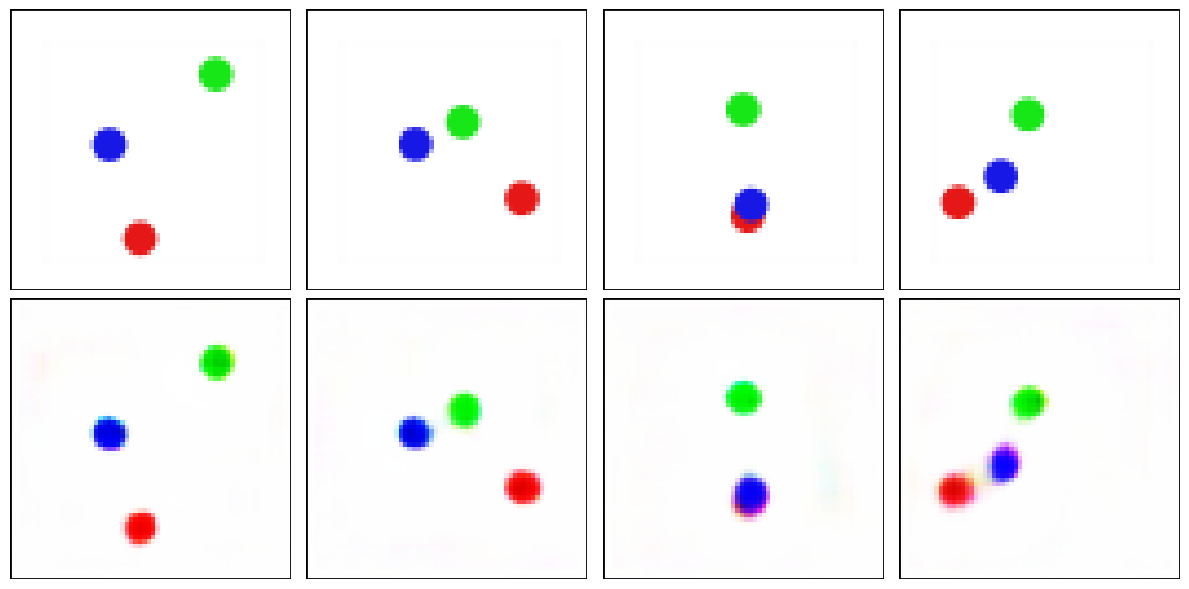

In [5]:
idxs = torch.randint(0, 1000, (4,))

zs_idxs = zs_obs[idxs]
xs_idxs = xs_obs[idxs]
ys_idxs = encoder1(xs_idxs)
xhats2_idxs = decoder1(ys_idxs)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Function to add a border around the image
def add_border(ax, color='black', lw=2):
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                     color=color, fill=False, lw=lw)
    ax.add_patch(rect)


fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# Ground truth images
i = 0
for j in range(4):
    axs[i, j].imshow(xs_idxs[j].detach().cpu().moveaxis(-3, -1).numpy())
    axs[i, j].axis('off')
    add_border(axs[i, j])

# Recovered images
i = 1
for j in range(4):
    axs[i, j].imshow(xhats2_idxs[j].detach().cpu().moveaxis(-3, -1).numpy())
    axs[i, j].axis('off')
    add_border(axs[i, j])

fig.tight_layout()
fig.savefig(os.path.join(data_dir, "image_reconstr_samples.png"))

display(zs_idxs)

tensor([[0.0137, 0.1963, 0.0166, 0.9306, 0.3642, 0.2844],
        [0.3561, 0.0204, 0.7907, 0.4966, 0.7888, 0.4473],
        [0.4709, 0.5921, 0.1123, 0.2383, 0.0333, 0.1937],
        [0.4641, 0.9767, 0.2337, 0.4497, 0.1980, 0.8325]])

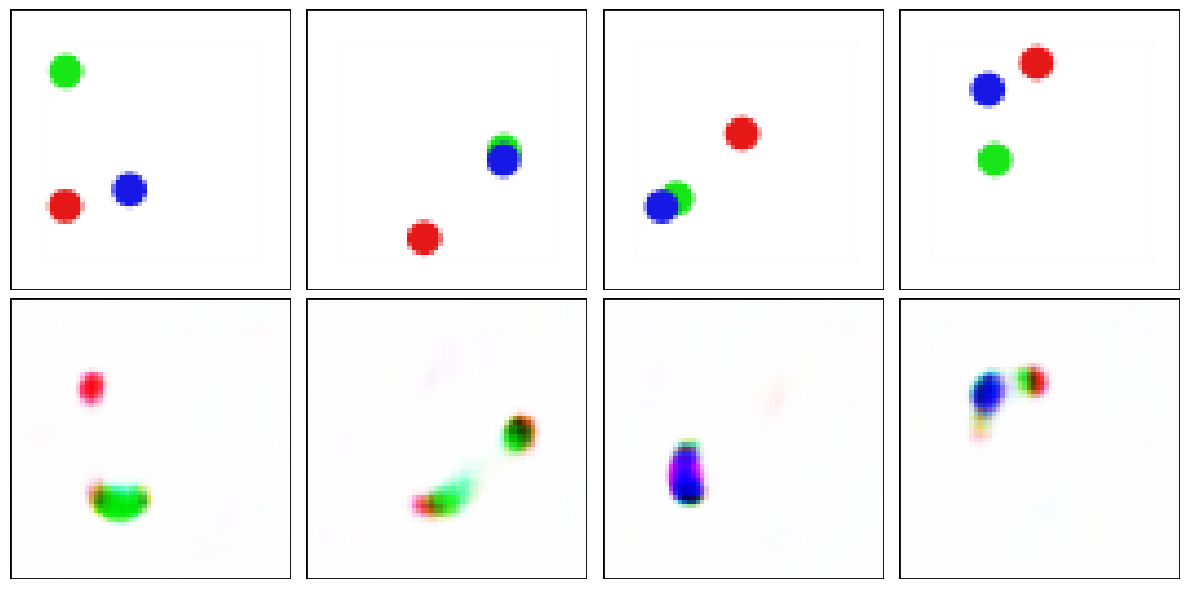

In [13]:
idxs = torch.randint(0, 1000, (4,))

zs_idxs = zs_obs[idxs]
xs_idxs = xs_obs[idxs]
zhats_idxs = encoder(xs_idxs)
xhats_idxs = decoder(zhats_idxs)

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Function to add a border around the image
def add_border(ax, color='black', lw=2):
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                     color=color, fill=False, lw=lw)
    ax.add_patch(rect)


fig, axs = plt.subplots(2, 4, figsize=(12, 6))

# Ground truth images
i = 0
for j in range(4):
    axs[i, j].imshow(xs_idxs[j].detach().cpu().moveaxis(-3, -1).numpy())
    axs[i, j].axis('off')
    add_border(axs[i, j])

# Recovered images
i = 1
for j in range(4):
    axs[i, j].imshow(xhats_idxs[j].detach().cpu().moveaxis(-3, -1).numpy())
    axs[i, j].axis('off')
    add_border(axs[i, j])

fig.tight_layout()
fig.savefig(os.path.join(data_dir, "image_reconstr_full_samples.png"))

display(zs_idxs)

In [ ]:
idx = torch.randint(0, zs_obs.shape[0], ())
idx

(0.49337512534882855, 0.08436338978387312)

In [ ]:
zhat_idx = encoder(xs_obs[idx:idx+1])[0]
xhat_idx = decoder(zhat_idx.unsqueeze(0))[0]

(np.float64(0.1700053002540707), 7.737996081814264)

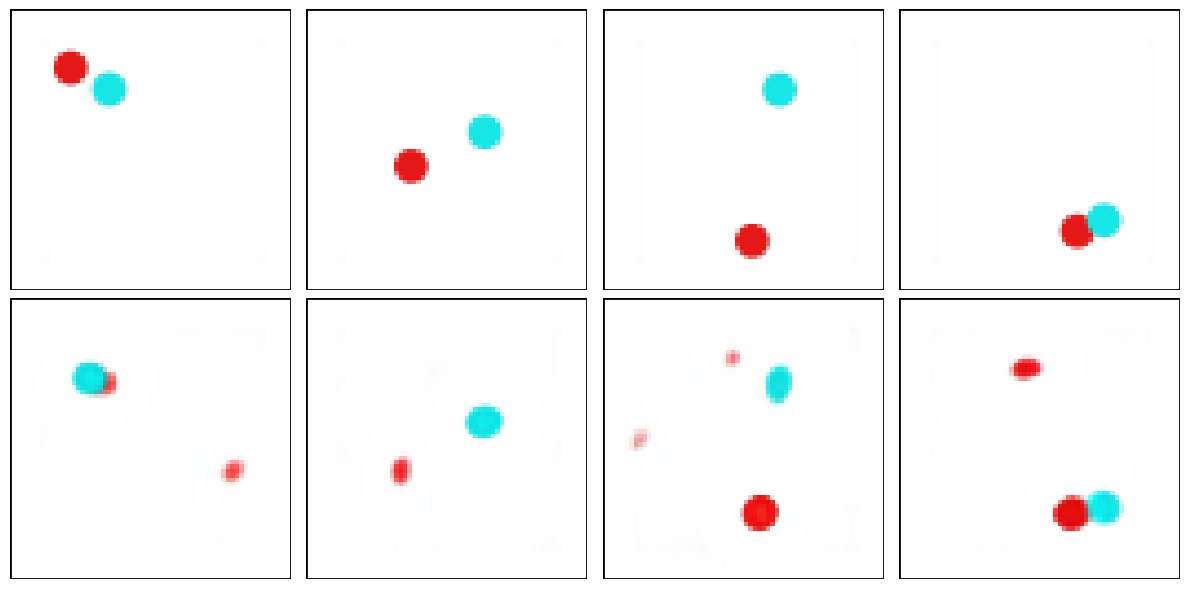

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(xhat_idx.detach().cpu().moveaxis(-3, -1).numpy())